In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR, LambdaLR
import sympy as sp

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [5]:
class Function_Selector(nn.Module):
    def __init__(self, functions, num_params, symbols, x_data, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data.to(self.device).requires_grad_(True)
        self.num_params = num_params
        self.max_params = max(num_params)
        self.total_params = sum(self.num_params)
        self.symbols = symbols

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=7, padding=3),
            nn.LayerNorm([8, 100]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7, padding=3),
            nn.LayerNorm([6, 100]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 100]),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(),
            nn.Linear(32, 20),
            nn.LayerNorm(20),
            nn.LeakyReLU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),           
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, padding=2),
            nn.LayerNorm([4, 32]),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, self.total_params),
        )

    def sympy_to_torch(self, expr, symbols):
        torch_funcs = {
            sp.Add: lambda *args: reduce(torch.add, args),
            sp.Mul: lambda *args: reduce(torch.mul, args),
            sp.Pow: torch.pow,
            sp.sin: torch.sin,
            sp.cos: torch.cos,
        }

        def torch_func(*args):
            def _eval(ex):
                if isinstance(ex, sp.Symbol):
                    return args[symbols.index(ex)]
                elif isinstance(ex, sp.Number):
                    return torch.full_like(args[0], float(ex))
                elif isinstance(ex, sp.Expr):
                    op = type(ex)
                    if op in torch_funcs:
                        return torch_funcs[op](*[_eval(arg) for arg in ex.args])
                    else:
                        raise ValueError(f"Unsupported operation: {op}")
                else:
                    raise ValueError(f"Unsupported type: {type(ex)}")
            
            return _eval(expr)

        return torch_func

    def evaluate(self, params, index):
        symbols = self.symbols[index]
        formula = self.functions[index]
        x = self.x_data
        torch_func = self.sympy_to_torch(formula, symbols)
        var_values = [params[:, j] for j in range(len(symbols)-1)] + [x.unsqueeze(1)]
        results = torch_func(*var_values)
        return results.swapaxes(0, 1)

    def forward(self, inputs):
        inputs = inputs.requires_grad_(True)
        outs = inputs.unsqueeze(1).to(self.device)
        outs = self.hidden_x1(outs)
        xfc = torch.reshape(outs, (-1, 256))
        xfc = self.hidden_xfc(xfc)

        outs = self.hidden_x2(outs)
        cnn_flat = self.flatten_layer(outs)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        start_index = 0
        losses = []
        outputs = []
        all_params = []
        
        for f in range(len(self.functions)):
            params = embedding[:, start_index:start_index+self.num_params[f]]
            all_params.append(F.pad(params, (0, self.max_params-self.num_params[f])))
            output = self.evaluate(params, f).to(self.device)
            outputs.append(output)
            loss = torch.mean(((inputs - output) ** 2), dim=1)
            losses.append(loss)
            start_index += self.num_params[f]        
        stacked_losses = torch.stack(losses).to(self.device)
        stacked_preds = torch.stack(outputs).to(self.device)
        weights = F.softmax(-stacked_losses, dim=0)
        best_out = torch.sum(weights.unsqueeze(2) * stacked_preds, dim=0)
        best_loss = torch.sum(weights * stacked_losses, dim=0)        
        best_func = weights.t()
        best_params = torch.sum(weights.unsqueeze(2) * torch.stack(all_params), dim=0)
        return best_out, best_loss, best_func, weights, best_params, outputs, losses, all_params

In [6]:
hold1 = torch.load('hold_data1.pth')
hold2 = torch.load('hold_data2.pth')
hold3 = torch.load('hold_data3.pth')

x_values = hold1['x_values'].to(device)
y_values = hold1['y_values'].flatten(0,1).to(device)
target_funcs = hold1['target_funcs'].to(device)
functions = hold2['formulas']
symbols = hold2['symbols']
params = hold3['param_values'].flatten(0,1).to(device)
num_params = hold3['num_params'].to(device)
full_params = hold3['full_params'].to(device)

/tmp/ipykernel_1076649/1675344362.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hold1 = torch.load('hold_data1.pth')
/tmp/ipykernel_1076649/1675344362.py:2: FutureWarn

In [7]:
class TripleDataset(Dataset):
    def __init__(self, data1, data2, data3):
        self.data1 = data1
        self.data2 = data2
        self.data3 = data3
        
    def __len__(self):
        return len(self.data1)
    
    def __getitem__(self, index):
        return self.data1[index], self.data2[index], self.data3[index]

# dataset = TripleDataset(y_values[0:10000], params[0:10000], target_funcs[:, 0:10])
dataset = TripleDataset(y_values, params, target_funcs)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

In [10]:
total_epochs = 200

def loss_func(output_y, target_y, output_params, target_params, output_function, target_function, lam):
    loss_class = nn.BCEWithLogitsLoss()
    y_loss = torch.mean((output_y - target_y) ** 2)
    params_loss = torch.mean((output_params - target_params) ** 2)
    function_loss = loss_class(output_function.swapaxes(0,1), target_function)
    return params_loss*lam + y_loss*(1-lam)

def lambda_rule(epoch):
    start_lambda = 1*100
    end_lambda = 0
    return start_lambda - (start_lambda - end_lambda) * min(epoch / total_epochs, 1.0)

def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

def compute_grad_stats(model):
    grad_norms = []
    grad_means = []
    grad_stds = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
            grad_means.append(param.grad.mean().item())
            grad_stds.append(param.grad.std().item())
    return np.mean(grad_norms), np.mean(grad_means), np.mean(grad_stds)

In [27]:
# model = Function_Selector(functions[0:10], num_params, symbols, x_values, device).to(device)
model = Function_Selector(functions, num_params, symbols, x_values, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
lambda_scheduler = LambdaLR(optimizer, lr_lambda=lambda_rule)

epoch : 0/200, loss = 0.04221829
Avg Grad Norm: 0.0048, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0005
--- 38.75731444358826 seconds ---
epoch : 1/200, loss = 0.00326783
Avg Grad Norm: 0.0027, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0003
--- 42.901230812072754 seconds ---
epoch : 2/200, loss = 0.00236598
Avg Grad Norm: 0.0023, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0002
--- 44.452348709106445 seconds ---
epoch : 3/200, loss = 0.00169999
Avg Grad Norm: 0.0037, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0004
--- 43.038317918777466 seconds ---
epoch : 4/200, loss = 0.00126471
Avg Grad Norm: 0.0041, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0005
--- 43.9222891330719 seconds ---
epoch : 5/200, loss = 0.00098639
Avg Grad Norm: 0.0032, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0004
--- 43.14754867553711 seconds ---
epoch : 6/200, loss = 0.00079983
Avg Grad Norm: 0.0033, Avg Grad Mean: -0.0000, Avg Grad Std: 0.0004
--- 45.68208026885986 seconds ---
epoch : 7/200, loss = 0.00074444
Avg Grad Norm: 0.004

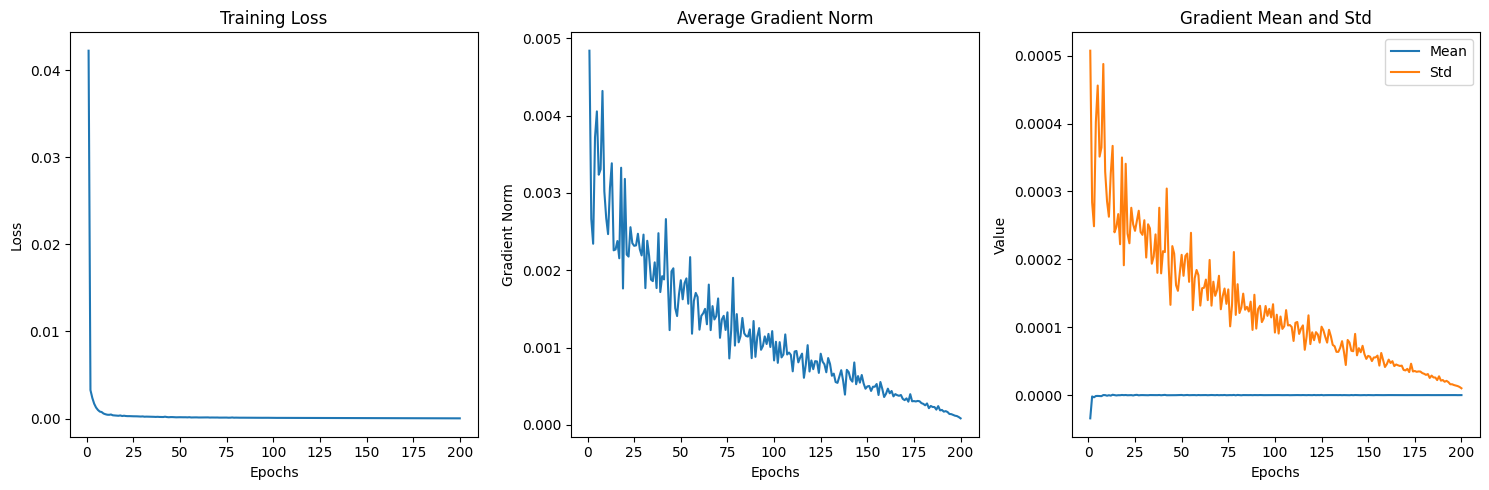

In [28]:
model.train()

train_losses = []
grad_norms = []
grad_means = []
grad_stds = []

for epoch in range(total_epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    epoch_grad_norms = []
    epoch_grad_means = []
    epoch_grad_stds = []

    for batch_idx, (inputs, true_params, true_func) in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        true_params = true_params.to(device)
        true_func = true_func.to(device)
        best_out,_,best_func,best_index,best_params,_,_,_= model(inputs)
        lam_val = lambda_scheduler.get_last_lr()[0]
        loss = loss_func(best_out, inputs, best_params, true_params, best_index.float(), true_func.float(), lam_val)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norm, grad_mean, grad_std = compute_grad_stats(model)
        epoch_grad_norms.append(grad_norm)
        epoch_grad_means.append(grad_mean)
        epoch_grad_stds.append(grad_std)

        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]

    scheduler.step()
    lambda_scheduler.step()
    train_loss /= total_num
    train_losses.append(train_loss)

    avg_grad_norm = np.mean(epoch_grad_norms)
    avg_grad_mean = np.mean(epoch_grad_means)
    avg_grad_std = np.mean(epoch_grad_stds)

    grad_norms.append(avg_grad_norm)
    grad_means.append(avg_grad_mean)
    grad_stds.append(avg_grad_std)

    print(f"epoch : {epoch}/{total_epochs}, loss = {train_loss:.8f}")
    print(f"Avg Grad Norm: {avg_grad_norm:.4f}, Avg Grad Mean: {avg_grad_mean:.4f}, Avg Grad Std: {avg_grad_std:.4f}")
    print(f"--- {time.time() - start_time} seconds ---")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, total_epochs + 1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(range(1, total_epochs + 1), grad_norms)
plt.title('Average Gradient Norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')

plt.subplot(1, 3, 3)
plt.plot(range(1, total_epochs + 1), grad_means, label='Mean')
plt.plot(range(1, total_epochs + 1), grad_stds, label='Std')
plt.title('Gradient Mean and Std')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
torch.save(model.state_dict(), 'function_selector_model.pth')

In [52]:
model = Function_Selector(functions, num_params, symbols, x_values, device).to(device)
model.load_state_dict(torch.load('function_selector_model.pth'))

/tmp/ipykernel_1076649/2657973290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('function_selector_model.pth'))


<All keys matched successfully>

best_func: tensor([6.6930e-02, 1.3545e-01, 7.3703e-04, 3.5141e-01, 3.2143e-01, 1.5863e-02,
        1.2919e-02, 2.6167e-02, 6.9094e-02, 5.0159e-21], device='cuda:3',
       grad_fn=<SelectBackward0>)
true_func: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:3')
best_params: tensor([ 0.5391,  0.3634,  0.3524,  0.3616, -0.1131], device='cuda:3',
       grad_fn=<SelectBackward0>)


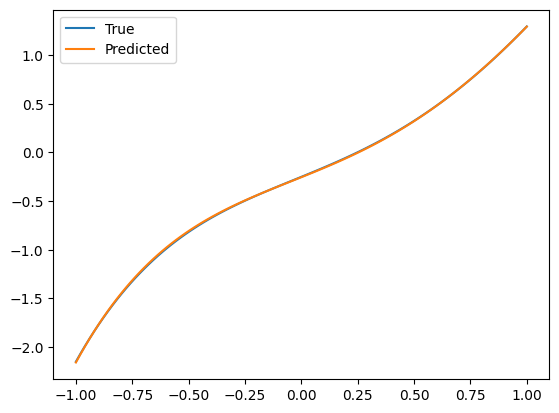

In [62]:
model.eval()
ran = np.random.randint(100000)
best_out, best_loss, best_func, best_indexes, best_params, stacked_preds, stacked_losses, all_params = model(y_values)
print(f"best_func: {best_func[ran]}")
print(f"true_func: {target_funcs[ran]}")
print(f"best_params: {best_params[ran]}")
plt.plot(x_values.detach().cpu().numpy(), y_values[ran].detach().cpu().numpy(), label='True')
plt.plot(x_values.detach().cpu().numpy(), best_out[ran].detach().cpu().numpy(), label='Predicted')
plt.legend()